In [5]:
!export CUDA_VISIBLE_DEVICES=1

In [6]:
# ga_ir_raw_emb_path: str | None = "../ir_20250606_2300.pkl",
# ga_cnmr_raw_emb_path: str | None = "../cnmr_pretrain_20250606_2302.pkl",
# ga_hnmr_raw_emb_path: str | None = "../hnmr_augment_pretrain_20250606_2301.pkl",
# ga_hsqc_raw_emb_path: str | None = "../hsqc_20250606_2303.pkl",

import pandas as pd

from molbind.data.analysis import aggregate_embeddings

# read all
ir_embeddings = pd.read_pickle("../ir_20250606_2300.pkl")
cnmr_embeddings = pd.read_pickle("../cnmr_pretrain_20250606_2302.pkl")
hnmr_embeddings = pd.read_pickle("../hnmr_augment_pretrain_20250606_2301.pkl")
hsqc_embeddings = pd.read_pickle("../hsqc_20250606_2303.pkl")

ir_embeddings_agg = aggregate_embeddings(ir_embeddings, modalities=["ir"], central_modality="smiles")
cnmr_embeddings_agg = aggregate_embeddings(cnmr_embeddings, modalities=["c_nmr"], central_modality="smiles")
hnmr_embeddings_agg = aggregate_embeddings(hnmr_embeddings, modalities=["h_nmr"], central_modality="smiles")
hsqc_embeddings_agg = aggregate_embeddings(hsqc_embeddings, modalities=["hsqc"], central_modality="smiles")

/home/mirzaa/projects/MoleculeBind/molbind/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from torch.nn import CosineSimilarity

cos_sim = CosineSimilarity(dim=1, eps=1e-6)

cosines = (
    cos_sim(ir_embeddings_agg["ir"], ir_embeddings_agg["smiles"]).cpu().numpy()
    + cos_sim(cnmr_embeddings_agg["c_nmr"], cnmr_embeddings_agg["smiles"]).cpu().numpy()
    + cos_sim(hnmr_embeddings_agg["h_nmr"], hnmr_embeddings_agg["smiles"]).cpu().numpy()
    + cos_sim(hsqc_embeddings_agg["hsqc"], hsqc_embeddings_agg["smiles"]).cpu().numpy()
) / 4


In [8]:
import matplotlib.pyplot as plt
import numpy as np

path = "cnmr_ir_hnmr_hsqc_seed_42_99_120"
data = pd.read_pickle(f"results_{path}.pkl")
data = data.sort_values(by="idx")
all_results = data.top1.tolist()
cosines = cosines[: len(all_results)]

# plt.figure(figsize=(5, 3))
plt.style.use("lamalab.mpl")
# can you plot the cosine similarity against the correctness mean binne

dataframe = pd.DataFrame(
    {"cosine_similarity": (cosines - cosines.min()) / (cosines.max() - cosines.min()), "correctness": all_results}
)

/tmp/ipykernel_3024935/1344046964.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dataframe.groupby("cosine_bin")


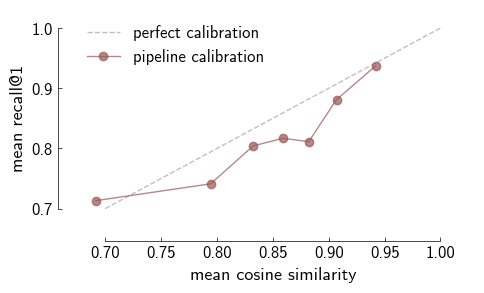

In [29]:
import matplotlib.font_manager as fm
from lama_aesthetics.plotutils import range_frame

# Define the number of bins to use
N_BINS = 7
# Create bins of equal width based on cosine similarity scores
# `pd.cut` is perfect for this. It assigns each row to a bin.
dataframe["cosine_bin"] = pd.qcut(dataframe["cosine_similarity"], q=N_BINS)

# Group by the new bins and calculate the necessary statistics for each bin:
# - The mean of `correctness` (this is the y-value, also called "accuracy")
# - The mean of `cosine_similarity` (this is the x-value, also called "confidence")
# - The number of items in each bin (`count`)
binned_data = (
    dataframe.groupby("cosine_bin")
    .agg(mean_cosine=("cosine_similarity", "mean"), mean_correctness=("correctness", "mean"), bin_count=("correctness", "count"))
    .reset_index()
)

# --- 3. Plotting the Calibration Curve ---
# Apply the desired style
plt.style.use("lamalab.mpl")
font_file = "CMU Sans Serif.ttf"
fm.FontManager().addfont(font_file)
plt.rcParams["font.family"] = "CMU Sans Serif"
fig, ax = plt.subplots(figsize=(5, 5/ 1.618))

# Plot the "perfect calibration" line (y=x)
ax.plot([.7, 1], [.7, 1], "k--", label="perfect calibration", alpha=0.25)

# Plot the model's calibration curve
ax.plot(
    binned_data["mean_cosine"],
    binned_data["mean_correctness"],
    "o-",
    label="pipeline calibration",
    color="#985656b3",
    markersize=6,
)

# --- 4. Enhancing the Plot ---

ax.set_ylim(0, binned_data["bin_count"].max() * 1.5)  # Give some space at the top

# Set labels and title
ax.set_xlabel("mean cosine similarity")
ax.set_ylabel("mean recall@1")

range_frame(ax=ax, x=np.array([0.7, 1]), y=np.array([0.7, 1]))
# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="upper left", frameon=False)

plt.tight_layout()
plt.savefig(f"figures/calibration_curve_{path}.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [31]:
binned_data["mean_correctness"], binned_data["mean_cosine"]

(0    0.713287
 1    0.741259
 2    0.804196
 3    0.816901
 4    0.811189
 5    0.881119
 6    0.937063
 Name: mean_correctness, dtype: float64,
 0    0.691622
 1    0.794361
 2    0.832382
 3    0.859180
 4    0.882109
 5    0.906990
 6    0.941904
 Name: mean_cosine, dtype: float32)

### Check retrieval

In [10]:
import hashlib
import multiprocessing as mp
import pickle
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import lru_cache
from pathlib import Path

import pandas as pd

from molbind.utils.spec2struct import smiles_to_molecular_formula

# Cache directory
CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True)


def get_file_hash(file_path: Path) -> str:
    """Generate a hash for file content to use as cache key."""
    with open(file_path, "rb") as f:
        content = f.read()
    return hashlib.md5(content).hexdigest()


def get_cache_path(file_path: Path) -> Path:
    """Generate cache file path."""
    file_hash = get_file_hash(file_path)
    return CACHE_DIR / f"{file_path.stem}_{file_hash}.pkl"


@lru_cache(maxsize=10000)
def cached_smiles_to_molecular_formula(smiles: str) -> str:
    """Cached version of smiles_to_molecular_formula to avoid repeated calculations."""
    return smiles_to_molecular_formula(smiles)


def process_single_file(args: tuple[Path, str]) -> pd.DataFrame:
    """Process a single file with caching."""
    file_path, expected_formula = args

    # Check if cached result exists
    cache_path = get_cache_path(file_path)
    if cache_path.exists():
        with open(cache_path, "rb") as f:
            cached_result = pickle.load(f)
        return cached_result
    df = pd.read_csv(file_path)

    # Apply molecular formula calculation with caching
    df["molecular_formula"] = df["smiles"].apply(cached_smiles_to_molecular_formula)

    # Filter by expected molecular formula
    filtered_df = df[df["molecular_formula"] == expected_formula].copy()

    with open(cache_path, "wb") as f:
        pickle.dump(filtered_df, f)
    return filtered_df


def parallel_process_files(max_workers: int = None) -> list[pd.DataFrame]:
    """Main function to process files in parallel with caching."""

    # Get list of files
    list_of_files = list(Path("cnmr_ir_hnmr_hsqc_seed_99").rglob("analyzer_candidates_output/*.csv"))

    # Sort files for consistent processing order
    list_of_files.sort()

    # Extract molecular formulas from filenames
    molecular_formulas = [file.name.split("_")[1].split(".")[0] for file in list_of_files]

    # Prepare arguments for parallel processing
    file_formula_pairs = list(zip(list_of_files, molecular_formulas, strict=False))

    # Determine number of workers
    if max_workers is None:
        max_workers = min(mp.cpu_count(), len(list_of_files))

    # Process files in parallel
    read_files = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_file = {executor.submit(process_single_file, args): args[0] for args in file_formula_pairs}

        # Collect results as they complete
        for future in as_completed(future_to_file):
            future_to_file[future]
            result = future.result()
            read_files.append(result)
    return read_files


def clear_cache():
    """Clear all cached files."""
    cache_files = list(CACHE_DIR.glob("*.pkl"))
    for cache_file in cache_files:
        cache_file.unlink()


# Process files with parallel execution and caching
read_files = parallel_process_files(max_workers=24)  # Adjust max_workers as needed

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("lamalab.mpl")  # Use the custom style for plotting
# Assume read_files is a list of pandas DataFrames,
# each containing 'tanimoto' and the various similarity columns.
# Example placeholder (replace with your actual data loading):
# import glob
# read_files = [pd.read_csv(f) for f in glob.glob("your_data_directory/*.csv")]
# Make sure your DataFrames have the required columns: 'tanimoto',
# 'hsqc_similarity', 'cnmr_similarity', 'hnmr_similarity', 'ir_similarity'.

# --- Define the retrieval function (same as before, with minor robustness) ---


def retrieval(metric: list | str):
    """
    Performs retrieval simulation based on specified metric(s).

    Args:
        metric: A string representing a single column name or a list of column names.

    Returns:
        A tuple containing:
            - retrieval: A dictionary with lists for "top_1", "top_3", "top_5" success flags.
            - no_sim_1_count: The number of files skipped because they didn't contain tanimoto=1.
    """
    retrieval = {"top_1": [], "top_3": [], "top_5": []}
    no_sim_1_count = 0

    if isinstance(metric, list):
        metrics_col_name = "sum_combined_metric"  # Use a unique name for the sum column
        metrics_list = metric  # Keep the list for column checking
    else:
        metrics_col_name = metric
        metrics_list = [metric]  # Make it a list for consistent checking

    for _, file in enumerate(read_files):
        # Check if the file contains a row with tanimoto == 1.0
        if 1.0 not in file["tanimoto"].to_numpy():
            no_sim_1_count += 1
            continue  # Skip this file as the target is not present

        current_file = file.copy()  # Work on a copy to avoid modifying original DataFrames

        # Ensure all required metric columns exist in the DataFrame
        if not all(col in current_file.columns for col in metrics_list):
            # print(f"Warning: Not all specified metric columns {metrics_list} found in file {i}. Skipping file.")
            no_sim_1_count += 1  # Count as skipped if columns are missing
            continue

        # if metric is a list add a new column summing the values
        if isinstance(metric, list):
            current_file[metrics_col_name] = current_file[metric].sum(axis=1)

        # Sort by the chosen metric(s)
        # Ensure the metric column exists before sorting (redundant check due to above, but safe)
        if metrics_col_name not in current_file.columns:
            # print(f"Warning: Metric column '{metrics_col_name}' not found after processing file {i}. Skipping file.")
            no_sim_1_count += 1  # Count as skipped if metric column is missing
            continue

        sorted_file = current_file.sort_values(by=metrics_col_name, ascending=False)

        # Check if tanimoto 1.0 is in the top N
        # Need to handle cases where the sorted_file might have fewer than N rows
        top_5_tanimoto = sorted_file["tanimoto"].to_numpy().tolist()[:5]
        top_3_tanimoto = sorted_file["tanimoto"].to_numpy().tolist()[:3]
        top_1_tanimoto = sorted_file["tanimoto"].to_numpy().tolist()[:1]

        retrieval["top_5"].append(1 if 1.0 in top_5_tanimoto else 0)
        retrieval["top_3"].append(1 if 1.0 in top_3_tanimoto else 0)
        retrieval["top_1"].append(1 if 1.0 in top_1_tanimoto else 0)

    return retrieval, no_sim_1_count


# --- Define the list of metrics/combinations to test ---

# Each tuple is (metric_input, label, number_of_modalities)
metric_combinations = [
    ("hsqc_similarity", "HSQC", 1),
    ("hnmr_similarity", "1H NMR", 1),
    ("cnmr_similarity", "13C NMR", 1),
    ("ir_similarity", "IR", 1),
    (["ir_similarity", "cnmr_similarity"], "Combined (IR, 13C)", 2),
    (["ir_similarity", "hnmr_similarity"], "Combined (IR, 1H NMR)", 2),
    (["ir_similarity", "hsqc_similarity"], "Combined (IR, HSQC)", 2),
    (["cnmr_similarity", "hnmr_similarity"], "Combined (13C NMR, 1H NMR)", 2),
    (["cnmr_similarity", "hsqc_similarity"], "Combined (13C NMR, HSQC)", 2),
    (["hnmr_similarity", "hsqc_similarity"], "Combined (1H NMR, HSQC)", 2),
    (["ir_similarity", "cnmr_similarity", "hnmr_similarity"], "Combined (IR, 13C, 1H)", 3),
    (["ir_similarity", "cnmr_similarity", "hsqc_similarity"], "Combined (IR, 13C, HSQC)", 3),
    (["ir_similarity", "hnmr_similarity", "hsqc_similarity"], "Combined (IR, 1H, HSQC)", 3),
    (["cnmr_similarity", "hnmr_similarity", "hsqc_similarity"], "Combined (13C, 1H, HSQC)", 3),
    (["ir_similarity", "cnmr_similarity", "hnmr_similarity", "hsqc_similarity"], "Combined (All)", 4),
]

# --- Perform Retrieval and Store Results for Grouping ---

all_results = []

for metric_input, label, num_modalities in metric_combinations:
    retrieval_dict, no_sim_count = retrieval(metric_input)

    # The number of files processed is the total minus those skipped
    num_processed_files = len(read_files) - no_sim_count

    if len(retrieval_dict["top_1"]) > 0:  # noqa: SIM108
        # Calculate rate among the files that were processed (i.e., contained tanimoto=1)
        rate = sum(retrieval_dict["top_1"]) / len(retrieval_dict["top_1"])
    else:
        rate = 0  # No files processed that contained tanimoto=1

    all_results.append({"label": label, "rate": rate, "modalities": num_modalities})
# Group results by the number of modalities
grouped_rates = {}
for result in all_results:
    mod = result["modalities"]
    if mod not in grouped_rates:
        grouped_rates[mod] = []
    grouped_rates[mod].append(result["rate"])

# Calculate average rate and standard deviation for each group
average_grouped_rates = {}
std_grouped_rates = {}  # Dictionary to store standard deviations

for mod, rates in grouped_rates.items():
    if rates:  # Ensure the list is not empty
        average_grouped_rates[mod] = np.mean(rates)
        std_grouped_rates[mod] = np.std(rates)  # Calculate standard deviation
    else:
        average_grouped_rates[mod] = 0
        std_grouped_rates[mod] = 0  # No std if no data

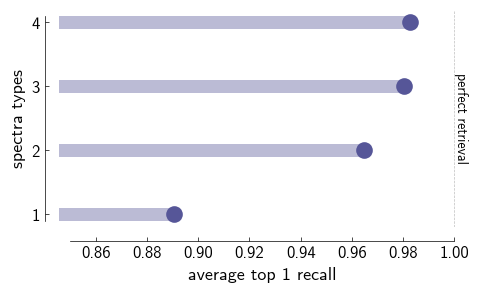

In [12]:
import matplotlib.font_manager as fm
from lama_aesthetics.plotutils import range_frame

fm.fontManager.addfont("CMU Sans Serif.ttf")

# Adjust figure size - wider than tall for horizontal bars

plt.figure(figsize=(5, 5 / 1.618))  # Adjusted for horizontal bars
sorted_modalities = sorted(average_grouped_rates.keys())
grouped_labels = ["1", "2", "3", "4"]  # Labels for the number of modalities
grouped_values = [average_grouped_rates[mod] for mod in sorted_modalities]
grouped_errors = [std_grouped_rates[mod] for mod in sorted_modalities]  # Get the standard deviations in order

# Use plt.barh for horizontal bars
# x-values are the rates, y-values are the labels
# xerr is used for horizontal error bars
plt.barh(grouped_labels, grouped_values, capsize=2, color="#565698b3", height=0.2, alpha=0.4)

# Swap axis labels
plt.xlabel("average top 1 recall")  # X-axis now represents the average rates
plt.ylabel("spectra types")  # Y-axis now represents the groups

# Set x-axis limit from 0 to slightly above 1
plt.xlim(0, 1.1)

color = "#565698b3"  # Color for the markers, matching the bar color
for i in range(len(grouped_values)):
    plt.plot(
        grouped_values[i] - 0.001,  # X-position (rate + error + small offset)
        i,  # Y-position (index of the bar)
        "o",  # Marker style (circle)
        markersize=12,  # Adjust marker size
        color=color,  # Match line color based on open source status
        alpha=1,  # Adjust transparency
        markerfacecolor=color,  # Fill with the same color
        markeredgewidth=0,  # Remove the marker edge/border
    )

# Optional: Add the average rate value next to each bar
# for i, rate in enumerate(grouped_values):
#     # Position text horizontally next to the bar + error bar
#     # x-position is the rate + error + a small offset
#     # y-position is the index of the bar
#     plt.text(0.99, i, f"{rate:.2f}", ha="left", va="center")


range_frame(x=np.array([0.85, 1]), y=np.array([-0.1, 3.1]), ax=plt.gca(), pad=0.03)
# line for perfect retrieval
plt.axvline(x=1, color="k", linestyle="--", linewidth=0.5, alpha=0.25, label="perfect retrieval")
# add horizontal text for perfect retrieval
plt.text(1.0, 1.5, "perfect retrieval", va="center", ha="left", fontsize=10, alpha=1, rotation=270, color="k")

plt.tight_layout()  # Adjust layout
plt.savefig("figures/grouped_retrieval_rates.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [13]:
all_results

[{'label': 'HSQC', 'rate': 0.9402228976697061, 'modalities': 1},
 {'label': '1H NMR', 'rate': 0.8044579533941236, 'modalities': 1},
 {'label': '13C NMR', 'rate': 0.939209726443769, 'modalities': 1},
 {'label': 'IR', 'rate': 0.8814589665653495, 'modalities': 1},
 {'label': 'Combined (IR, 13C)', 'rate': 0.9817629179331308, 'modalities': 2},
 {'label': 'Combined (IR, 1H NMR)',
  'rate': 0.950354609929078,
  'modalities': 2},
 {'label': 'Combined (IR, HSQC)', 'rate': 0.9706180344478217, 'modalities': 2},
 {'label': 'Combined (13C NMR, 1H NMR)',
  'rate': 0.9635258358662614,
  'modalities': 2},
 {'label': 'Combined (13C NMR, HSQC)',
  'rate': 0.9726443768996961,
  'modalities': 2},
 {'label': 'Combined (1H NMR, HSQC)',
  'rate': 0.9544072948328267,
  'modalities': 2},
 {'label': 'Combined (IR, 13C, 1H)',
  'rate': 0.9827760891590679,
  'modalities': 3},
 {'label': 'Combined (IR, 13C, HSQC)',
  'rate': 0.9848024316109423,
  'modalities': 3},
 {'label': 'Combined (IR, 1H, HSQC)',
  'rate': 0.

### Plot max initial tanimoto similarity vs performance

In [14]:
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import DataStructs
from scipy.stats import gaussian_kde

CSV_DIR = Path("cnmr_ir_hnmr_hsqc_seed_99/analyzer_candidates_output")
RESULTS_PICKLE_FILE = "results_cnmr_ir_hnmr_hsqc_seed_42_99_120.pkl"
FONT_FILE = "CMU Sans Serif.ttf"

font_path = Path(FONT_FILE)

fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = "CMU Sans Serif"

all_results_merged_seeds = pd.read_pickle(RESULTS_PICKLE_FILE)


In [15]:
test_set = pd.read_parquet("../../data/test_split.parquet")

In [16]:
from rdkit.Chem import Descriptors

list_of_names = sorted(CSV_DIR.rglob("*.csv"), key=lambda x: int(x.stem.split("_")[0]))


def compute_fingerprint(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    return Chem.RDKFingerprint(mol, maxPath=6, fpSize=2048) if mol else None


def tanimoto_similarity(smiles1: str, smiles2: str) -> float:
    if not smiles1 or not smiles2:
        return 0.0
    fp1, fp2 = compute_fingerprint(smiles1), compute_fingerprint(smiles2)
    return DataStructs.FingerprintSimilarity(fp1, fp2) if fp1 and fp2 else 0.0


def bertz_complexity(smiles):
    """Compute Bertz complexity index for a molecule."""
    if pd.isna(smiles) or smiles == "":
        return None

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return Descriptors.BertzCT(mol)


analysis_data = []
for file_path in list_of_names:
    idx = int(file_path.stem.split("_")[0])
    data = pd.read_csv(file_path)
    filtered_data = data[data["tanimoto"] < 1.0]
    original_smiles = test_set.iloc[idx]["smiles"]
    print(f"Processing idx: {idx}, original smiles: {original_smiles}")
    max_tanimoto = tanimoto_similarity(
        filtered_data.sort_values(by="similarity", ascending=False).smiles.tolist()[0], original_smiles
    )
    max_similarity = filtered_data.sort_values(by="similarity", ascending=False).similarity.tolist()[0] / 4
    top1_result = all_results_merged_seeds[all_results_merged_seeds["idx"] == idx]

    top1_status = top1_result["top1"].iloc[0]
    analysis_data.append(
        {
            "idx": idx,
            "max_tanimoto": max_tanimoto,
            "top1": top1_status,
            "max_similarity": max_similarity,
            "bertz": bertz_complexity(original_smiles),
        }
    )

df = pd.DataFrame(analysis_data)


Processing idx: 0, original smiles: COC(=O)[C@](N)(N=C=S)C(C)C
Processing idx: 1, original smiles: [N-]=[N+]=NC[C@@H]1CNc2cccc(-c3ccccc3F)c2O1
Processing idx: 2, original smiles: CNC(=O)CC(c1ccccc1)c1cccc2cn[nH]c12
Processing idx: 3, original smiles: O=c1c2sc3c(c2cnn1-c1nccc(Cl)c1CO)CCCC3
Processing idx: 4, original smiles: O=S(=O)(c1cccc2cnccc12)N1CCC(O)C1
Processing idx: 5, original smiles: Cc1cc(C)cc(C2=CCC(C)(C)c3ccc(C#Cc4ccc(C(=O)O)cc4)cc32)c1
Processing idx: 6, original smiles: COc1ccc(C)cc1C1(N2C[C@H](OCCC#N)C[C@H]2C(=O)N(C)C)C(=O)Nc2ccc(Cl)cc21
Processing idx: 7, original smiles: O=C(N[C@@H]1CCC[C@@H]1C(=O)N1CC[C@@H]2[C@H](c3ccsc3)Nc3ccccc3[C@@H]21)c1ccccc1
Processing idx: 8, original smiles: CCOc1cc(-c2cccc(F)c2)c(C2CC2)cc1C=O
Processing idx: 9, original smiles: Nc1ncc(-c2nc(N[C@@H]3CCCC[C@@H]3N)c(F)c3c2C(=O)NC3)s1
Processing idx: 10, original smiles: CCN(CC)C(=O)NC
Processing idx: 11, original smiles: COc1cc(C)c(/C=C/c2nc3c([nH]2)c(=O)n(C)c(=O)n3C)cc1C
Processing idx: 12, ori

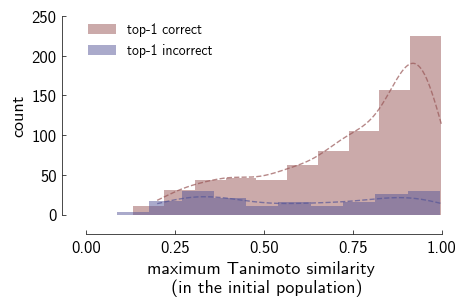

In [17]:
from lama_aesthetics.plotutils import range_frame

plt.style.use("lamalab.mpl")  # Use the custom style for plotting
FONT_FILE = "CMU Sans Serif.ttf"

font_path = Path(FONT_FILE)

fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = "CMU Sans Serif"

plt.figure(figsize=(5, 5 / 1.618), dpi=100)
df = df[df.max_tanimoto != 1.0]
plt.hist(
    df[df["top1"] == 1]["max_tanimoto"],
    bins=10,
    alpha=0.5,
    label="top-1 correct",
    color="#985656b3",
    # keep only contour,
    # histtype="step",
    # density=True,
)
plt.hist(
    df[df["top1"] == 0]["max_tanimoto"],
    bins=10,
    alpha=0.5,
    label="top-1 incorrect",
    color="#565698b3",
    # density=True,
)
binwidth = (df["max_tanimoto"].max() - df["max_tanimoto"].min()) / 10
# Data for histograms
correct_data = df[df["top1"] == 1]["max_tanimoto"]
incorrect_data = df[df["top1"] == 0]["max_tanimoto"]

# add kde
scale_correct = len(correct_data) * binwidth
scale_incorrect = len(incorrect_data) * binwidth

# Add scaled KDEs
kde_incorrect = gaussian_kde(incorrect_data)
kde_correct = gaussian_kde(correct_data)
x = np.linspace(0.2, 1.0, 1000)

# --- KEY CHANGE: Multiply KDE output by the scaling factor ---
plt.plot(x, kde_incorrect(x) * scale_incorrect, color="#565698b3", linestyle="--")
plt.plot(x, kde_correct(x) * scale_correct, color="#985656b3", linestyle="--")

plt.xlabel("maximum Tanimoto similarity \n (in the initial population)")
plt.ylabel("count")

plt.xlim(0.2, 1.0)
# plt.ylim(0, 3.0)

plt.legend(bbox_to_anchor=(0, 1), loc="upper left", fontsize=10)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.xticks(np.arange(0, 1.25, 0.25))
# plt.yticks(np.arange(0, 4.1, 1))
range_frame(x=np.array([0, 1.0]), y=np.array([0, 250]), ax=plt.gca(), pad=0.03)
plt.savefig("figures/tanimoto_histogram.pdf", bbox_inches="tight", dpi=300)


### Plot by max cosine similarity

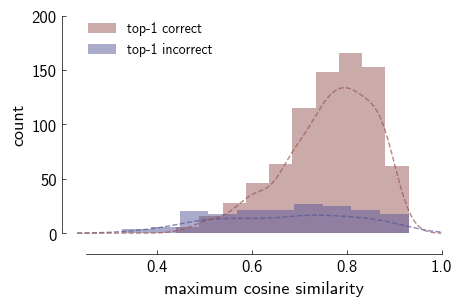

In [18]:
from lama_aesthetics.plotutils import range_frame

plt.style.use("lamalab.mpl")
FONT_FILE = "CMU Sans Serif.ttf"

font_path = Path(FONT_FILE)

fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = "CMU Sans Serif"

plt.figure(figsize=(5, 5 / 1.618), dpi=100)

plt.hist(
    df[df["top1"] == 1]["max_similarity"],
    bins=10,
    alpha=0.5,
    label="top-1 correct",
    color="#985656b3",
    # keep only contour,
    # histtype="step",
    # density=True,
)
plt.hist(
    df[df["top1"] == 0]["max_similarity"],
    bins=10,
    alpha=0.5,
    label="top-1 incorrect",
    color="#565698b3",
    # density=True,
)
binwidth = (df["max_similarity"].max() - df["max_similarity"].min()) / 15
# Data for histograms
correct_data = df[df["top1"] == 1]["max_similarity"]
incorrect_data = df[df["top1"] == 0]["max_similarity"]

# add kde
scale_correct = len(correct_data) * binwidth
scale_incorrect = len(incorrect_data) * binwidth

# Add scaled KDEs
kde_incorrect = gaussian_kde(incorrect_data)
kde_correct = gaussian_kde(correct_data)
# x = np.linspace(
x = np.linspace(0.2, 1.0, 1000)  # Adjusted to match the range of max_similarity
# --- KEY CHANGE: Multiply KDE output by the scaling factor ---
plt.plot(x, kde_incorrect(x) * scale_incorrect, color="#565698b3", linestyle="--")
plt.plot(x, kde_correct(x) * scale_correct, color="#985656b3", linestyle="--")

plt.xlabel("maximum cosine similarity")
plt.ylabel("count")

# plt.xlim(0.2, 1.0)
# plt.ylim(0, 3.0)

plt.legend(bbox_to_anchor=(0, 1), loc="upper left", fontsize=10)
plt.tight_layout(rect=[0, 0, 0.95, 1])
# plt.xticks(np.arange(0, 1.25, 0.25))
# plt.yticks(np.arange(0, 4.1, 1))

range_frame(x=np.array([0.25, 1.0]), y=np.array([0, 200]), ax=plt.gca(), pad=0.03)
plt.savefig("figures/cosine_histogram.pdf", bbox_inches="tight", dpi=300)


### Bertz complexity

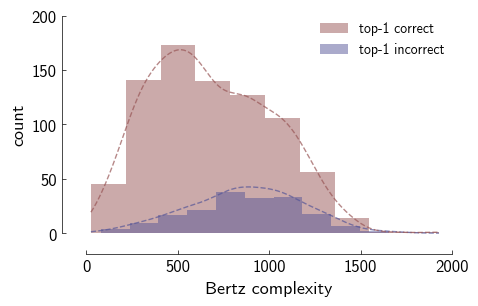

In [19]:
from lama_aesthetics.plotutils import range_frame

plt.style.use("lamalab.mpl")
FONT_FILE = "CMU Sans Serif.ttf"

font_path = Path(FONT_FILE)

fm.fontManager.addfont(font_path)
plt.rcParams["font.family"] = "CMU Sans Serif"

plt.figure(figsize=(5, 5 / 1.618), dpi=100)

plt.hist(
    df[df["top1"] == 1]["bertz"],
    bins=10,
    alpha=0.5,
    label="top-1 correct",
    color="#985656b3",
    # keep only contour,
    # histtype="step",
    # density=True,
)
plt.hist(
    df[df["top1"] == 0]["bertz"],
    bins=10,
    alpha=0.5,
    label="top-1 incorrect",
    color="#565698b3",
    # density=True,
)
binwidth = (df["bertz"].max() - df["bertz"].min()) / 10
# Data for histograms
correct_data = df[df["top1"] == 1]["bertz"]
incorrect_data = df[df["top1"] == 0]["bertz"]

# add kde
scale_correct = len(correct_data) * binwidth
scale_incorrect = len(incorrect_data) * binwidth

# Add scaled KDEs
kde_incorrect = gaussian_kde(incorrect_data)
kde_correct = gaussian_kde(correct_data)
# x = np.linspace(
x = np.linspace(np.min(df["bertz"]), np.max(df["bertz"]), 1000)  # Adjusted to match the range of bertz complexity
# --- KEY CHANGE: Multiply KDE output by the scaling factor ---
plt.plot(x, kde_incorrect(x) * scale_incorrect, color="#565698b3", linestyle="--")
plt.plot(x, kde_correct(x) * scale_correct, color="#985656b3", linestyle="--")

plt.xlabel("Bertz complexity")
plt.ylabel("count")

# plt.xlim(0.2, 1.0)
# plt.ylim(0, 3.0)

plt.legend(bbox_to_anchor=(0.6, 1), loc="upper left", fontsize=10)
plt.tight_layout(rect=[0, 0, 0.95, 1])
# plt.xticks(np.arange(0, 1.25, 0.25))
# plt.yticks(np.arange(0, 4.1, 1))

range_frame(x=np.array([0, 2000]), y=np.array([0, 200]), ax=plt.gca(), pad=0.03)

plt.savefig("figures/bertz_histogram.pdf", bbox_inches="tight", dpi=300)


### Retrieval metrics plot

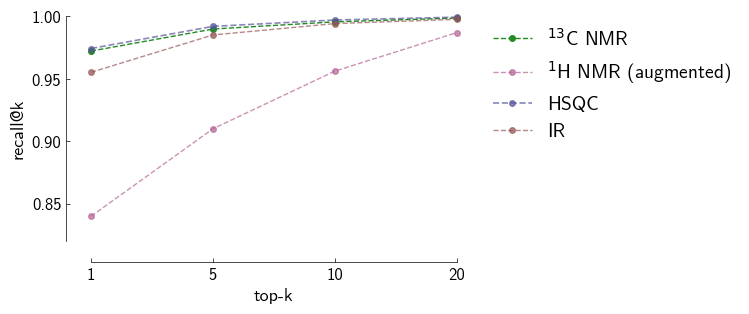

In [25]:
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lama_aesthetics.plotutils import range_frame

FONT_FILE = "CMU Sans Serif.ttf"

font_path = Path(FONT_FILE)

fm.fontManager.addfont(font_path)
# load lamalab style
plt.style.use("lamalab.mpl")
plt.rcParams["font.family"] = "CMU Sans Serif"

plt.figure(figsize=(5, 5 / 1.618), dpi=100)

read_cnmr = pd.read_csv("../cnmr_pretrain_retrieval_metrics.csv")
read_hnmr = pd.read_csv("../hnmr_augment_pretrain_retrieval_metrics.csv")
read_hsqc = pd.read_csv("../hsqc_retrieval_metrics.csv")
read_ir = pd.read_csv("../ir_retrieval_metrics.csv")
read_hnmr_no_aug = pd.read_csv("../hnmr_pretrain_retrieval_metrics.csv")

# smiles_DB__c_nmr_Query
# smiles_DB__h_nmr_Query
# smiles_DB__IR_Query
# smiles_DB__hsqc_Query
# row 1 Recall@1, row 2 Recall@5, row 3 Recall@10, row 4 Recall@20

plt.ylim(0.83, 1.0)
plt.plot(
    read_cnmr["smiles_DB__c_nmr_Query"].values,
    label=r"$^{13}$C NMR",
    marker="o",
    markersize=4,
    # color="#565698b3",
    color="#228B22",
    linestyle="--",
)
plt.plot(
    read_hnmr["smiles_DB__h_nmr_Query"].values,
    label=r"$^1$H NMR (augmented)",
    marker="o",
    markersize=4,
    color="#b56598b3",
    linestyle="--",
)

plt.plot(
    read_hsqc["smiles_DB__hsqc_Query"].values,
    label="HSQC",
    marker="o",
    markersize=4,
    linewidth=1.2,
    linestyle="--",
    color="#565698b3",
)

plt.plot(
    read_ir["smiles_DB__ir_Query"].values,
    label="IR",
    marker="o",
    markersize=4,
    linestyle="--",
    color="#985656b3",
)
font = {"family": "CMU Sans Serif", "size": 18}

SMALL_SIZE = 18
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

# plt.rc("axes", titlesize=SMALL_SIZE)
# plt.rc("axes", labelsize=SMALL_SIZE)
# plt.rc("xtick", labelsize=SMALL_SIZE)
# plt.rc("ytick", labelsize=SMALL_SIZE)
# plt.tick_params(labelsize=14)
plt.xticks([0, 1, 2, 3], ["1", "5", "10", "20"])
plt.xlabel("top-k")
plt.ylabel("recall@k")

plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=14)
range_frame(x=np.array([0, 3]), y=np.array([0.82, 1.0]), ax=plt.gca(), pad=0.03)
plt.savefig("figures/retrieval_metrics.pdf", bbox_inches="tight", dpi=300)

### Figure 3

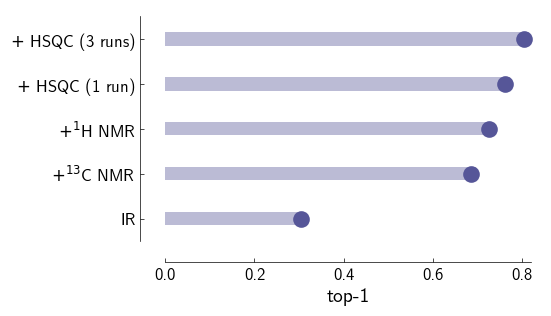

In [2]:
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lama_aesthetics.plotutils import range_frame

FONT_FILE = "CMU Sans Serif.ttf"

font_path = Path(FONT_FILE)

fm.fontManager.addfont(font_path)
# load lamalab style
plt.style.use("lamalab.mpl")
plt.rcParams["font.family"] = "CMU Sans Serif"

d = 5
plt.figure(figsize=(d, d / 1.618), dpi=100)

pipe_performance = {
    r"IR": 0.3140,
    # r"Alberts et al. 2024": 0.666,
    # r"Alberts et al. 2025": 0.731,
    r"$+ ^{13}$C NMR": 0.6960,
    r"$ + ^1$H NMR": 0.7360,
    r"$+$ HSQC (1 run)": 0.7730,
    r"$+$ HSQC (3 runs)": 0.8150,
}

# barplot horizontal
plt.barh(
    list(pipe_performance.keys()),
    list(pipe_performance.values()),
    color="#565698b3",
    alpha=0.4,
    height=0.3,
)
# add dots for the values
for i, value in enumerate(pipe_performance.values()):
    plt.plot(
        value - 0.01,  # X-position (value + error + small offset)
        i,  # Y-position (index of the bar)
        "o",  # Marker style (circle)
        markersize=12,  # Adjust marker size
        color="#565698b3",  # Match line color based on open source status
        alpha=1,  # Adjust transparency
        markerfacecolor="#565698b3",  # Fill with the same color
        markeredgewidth=0,  # Remove the marker edge/border
    )

range_frame(x=np.array([0, 0.82]), y=np.array([-0.5, 4.5]), ax=plt.gca(), pad=0.03)
plt.xlabel("top-1", fontsize=14)
# plt.ylabel("spectra types", fontsize=14)
plt.savefig("figures/pipeline_performance.pdf", bbox_inches="tight", dpi=300)

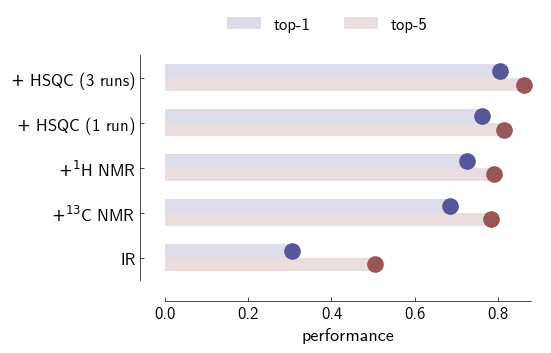

In [5]:
import os
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lama_aesthetics.plotutils import range_frame

FONT_FILE = "CMU Sans Serif.ttf"
font_path = Path(FONT_FILE)
fm.fontManager.addfont(font_path)
# Set font family
plt.rcParams["font.family"] = "CMU Sans Serif"

d = 5
plt.figure(figsize=(d, d / 1.618), dpi=100)
pipe_performance = {
    r"IR": 0.3140,
    r"$+ ^{13}$C NMR": 0.6960,
    r"$ + ^1$H NMR": 0.7360,
    r"$+$ HSQC (1 run)": 0.7730,
    r"$+$ HSQC (3 runs)": 0.8150,
}
# New data for top-5 performance
pipe_performance_top5 = {
    r"IR": 0.5150,
    r"$+ ^{13}$C NMR": 0.7950,
    r"$ + ^1$H NMR": 0.8020,
    r"$+$ HSQC (1 run)": 0.8250,
    r"$+$ HSQC (3 runs)": 0.8740,
}


labels = list(pipe_performance.keys())
y_pos = np.arange(len(labels))
bar_height = 0.3

# barplot horizontal for top-1 performance
plt.barh(
    y_pos + bar_height / 2,
    list(pipe_performance.values()),
    color="#565698b3",
    alpha=0.2,
    height=bar_height,
    label="top-1",
)

# barplot horizontal for top-5 performance
plt.barh(
    y_pos - bar_height / 2,
    list(pipe_performance_top5.values()),
    color="#985656b3",
    alpha=0.2,
    height=bar_height,
    label="top-5",
)

# add dots for the top-1 values
for i, value in enumerate(pipe_performance.values()):
    plt.plot(
        value - 0.01,  # X-position (value + error + small offset)
        y_pos[i] + bar_height / 2,  # Y-position (center of the bar)
        "o",  # Marker style (circle)
        markersize=12,  # Adjust marker size
        color="#565698b3",  # Match line color
        alpha=1,  # Adjust transparency
        markerfacecolor="#565698b3",  # Fill with the same color
        markeredgewidth=0,  # Remove the marker edge/border
    )

# add dots for the top-5 values
for i, value in enumerate(pipe_performance_top5.values()):
    plt.plot(
        value - 0.01,
        y_pos[i] - bar_height / 2,
        "o",
        markersize=12,
        color="#985656b3",
        alpha=1,
        markerfacecolor="#985656b3",
        markeredgewidth=0,
    )


plt.yticks(y_pos, labels)

range_frame(x=np.array([0, 0.88]), y=np.array([-0.5, 4.5]), ax=plt.gca(), pad=0.03)

plt.xlabel("performance")
plt.legend(bbox_to_anchor=(0.15, 1.2), loc="upper left", ncol=2)
plt.savefig("figures/pipeline_performance_with_top5.pdf", bbox_inches="tight", dpi=300)


### Experimental data performance

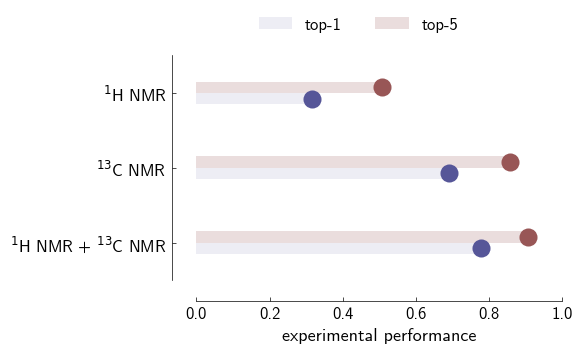

In [6]:
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lama_aesthetics.plotutils import range_frame

FONT_FILE = "CMU Sans Serif.ttf"
font_path = Path(FONT_FILE)
fm.fontManager.addfont(font_path)
# Set font family
plt.rcParams["font.family"] = "CMU Sans Serif"

d = 5
plt.figure(figsize=(d, d / 1.618), dpi=100)
pipe_performance = {
    r"$^1$H NMR + $^{13}$C NMR": 0.7883,
    r"$^{13}$C NMR": 0.7000,
    r"$ ^1$H NMR": 0.3250,

}

pipe_performance_top5 = {
    r"$^1$H NMR + $^{13}$C NMR": 0.9167,
    r"$^{13}$C NMR": 0.8687,
    r"$ ^1$H NMR": 0.5167,
}


labels = list(pipe_performance.keys())
y_pos = np.arange(len(labels))
bar_height = 0.15

# barplot horizontal for top-1 performance
plt.barh(
    y_pos - bar_height / 2,
    list(pipe_performance.values()),
    color="#565698b3",
    alpha=0.1,
    height=bar_height,
    label="top-1",
)

# barplot horizontal for top-5 performance
plt.barh(
    y_pos + bar_height / 2,
    list(pipe_performance_top5.values()),
    color="#985656b3",
    alpha=0.2,
    height=bar_height,
    label="top-5",
)

# add dots for the top-1 values
for i, value in enumerate(pipe_performance.values()):
    plt.plot(
        value - 0.01,  # X-position (value + error + small offset)
        y_pos[i] - bar_height / 2,  # Y-position (center of the bar)
        "o",  # Marker style (circle)
        markersize=13,  # Adjust marker size
        color="#565698b3",  # Match line color
        alpha=1,  # Adjust transparency
        markerfacecolor="#565698b3",  # Fill with the same color
        markeredgewidth=0,  # Remove the marker edge/border
    )

# add dots for the top-5 values
for i, value in enumerate(pipe_performance_top5.values()):
    plt.plot(
        value - 0.01,
        y_pos[i] + bar_height / 2,
        "o",
        markersize=13,
        color="#985656b3",
        alpha=1,
        markerfacecolor="#985656b3",
        markeredgewidth=0,
    )


plt.yticks(y_pos, labels)

range_frame(x=np.array([0, 1.0]), y=np.array([-0.5, 2.5]), ax=plt.gca(), pad=0.03)

plt.xlabel("experimental performance")
plt.legend(bbox_to_anchor=(0.15, 1.2), loc="upper left", ncol=2)
plt.savefig("figures/experimental_performance_with_top5.pdf", bbox_inches="tight", dpi=300)


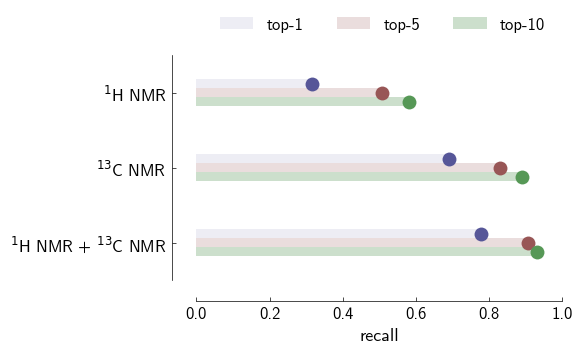

In [8]:
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lama_aesthetics.plotutils import range_frame

FONT_FILE = "CMU Sans Serif.ttf"
font_path = Path(FONT_FILE)
fm.fontManager.addfont(font_path)
# Set font family
plt.rcParams["font.family"] = "CMU Sans Serif"

d = 5
plt.figure(figsize=(d, d / 1.618), dpi=100)

# Performance data for different metrics
pipe_performance = {
    r"$^1$H NMR + $^{13}$C NMR": 0.7883,
    r"$^{13}$C NMR": 0.7000,
    r"$ ^1$H NMR": 0.3250,
}

pipe_performance_top5 = {
    r"$^1$H NMR + $^{13}$C NMR": 0.9167,
    r"$^{13}$C NMR": 0.8417,
    r"$ ^1$H NMR": 0.5167,
}

# Add top-10 performance data (you'll need to replace these with actual values)
pipe_performance_top10 = {
    r"$^1$H NMR + $^{13}$C NMR": 0.9417,  # Replace with actual values
    r"$^{13}$C NMR": 0.9000,              # Replace with actual values
    r"$ ^1$H NMR": 0.5917,                # Replace with actual values
}

labels = list(pipe_performance.keys())
y_pos = np.arange(len(labels))
bar_height = 0.12  # Reduced to accommodate three bars

# Colors for each metric
color_top1 = "#565698b3"
color_top5 = "#985656b3"
color_top10 = "#569856b3"  # Green for top-10

# Barplot horizontal for top-1 performance
plt.barh(
    y_pos + bar_height,
    list(pipe_performance.values()),
    color=color_top1,
    alpha=0.1,
    height=bar_height,
    label="top-1",
)

# Barplot horizontal for top-5 performance
plt.barh(
    y_pos,
    list(pipe_performance_top5.values()),
    color=color_top5,
    alpha=0.2,
    height=bar_height,
    label="top-5",
)

# Barplot horizontal for top-10 performance
plt.barh(
    y_pos - bar_height,
    list(pipe_performance_top10.values()),
    color=color_top10,
    alpha=0.3,
    height=bar_height,
    label="top-10",
)

# Add dots for the top-1 values
for i, value in enumerate(pipe_performance.values()):
    plt.plot(
        value - 0.01,
        y_pos[i] + bar_height,
        "o",
        markersize=10,
        color=color_top1,
        alpha=1,
        markerfacecolor=color_top1,
        markeredgewidth=0,
    )

# Add dots for the top-5 values
for i, value in enumerate(pipe_performance_top5.values()):
    plt.plot(
        value - 0.01,
        y_pos[i],
        "o",
        markersize=10,
        color=color_top5,
        alpha=1,
        markerfacecolor=color_top5,
        markeredgewidth=0,
    )

# Add dots for the top-10 values
for i, value in enumerate(pipe_performance_top10.values()):
    plt.plot(
        value - 0.01,
        y_pos[i] - bar_height,
        "o",
        markersize=10,
        color=color_top10,
        alpha=1,
        markerfacecolor=color_top10,
        markeredgewidth=0,
    )

plt.yticks(y_pos, labels)

range_frame(x=np.array([0, 1.0]), y=np.array([-0.5, 2.5]), ax=plt.gca(), pad=0.03)

plt.xlabel("recall")
plt.legend(bbox_to_anchor=(0.05, 1.2), loc="upper left", ncol=3)
plt.savefig("figures/experimental_performance_with_top10.pdf", bbox_inches="tight", dpi=300)
plt.show()


### Experimental molecules analysis

In [47]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

data = pd.read_parquet("../../data/nmrshiftdb/hnmr_cnmr_validation_set.parquet")
data["heavy_atom_count"] = data["smiles"].apply(lambda x: Chem.MolFromSmiles(x).GetNumHeavyAtoms() if x else 0)
data["bertz_complexity"] = data["smiles"].apply(
    lambda x: Descriptors.BertzCT(Chem.MolFromSmiles(x)) if x else 0
)
print(np.average(data["heavy_atom_count"]))

10.525


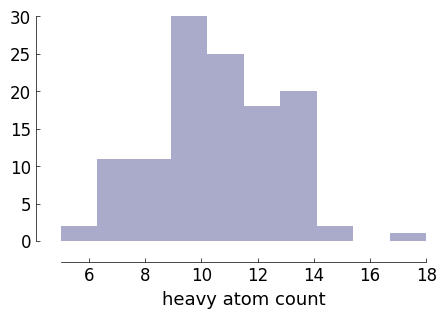

In [64]:
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from lama_aesthetics.plotutils import range_frame

plt.figure(figsize=(5, 5 / 1.618), dpi=100)
plt.style.use("lamalab.mpl")  # Use the custom style for plotting
FONT_FILE = "CMU Sans Serif.ttf"
font_path = Path(FONT_FILE)
fm.fontManager.addfont(font_path)

plt.hist(
    data["heavy_atom_count"],
    bins=10,
    alpha=0.5,
    label="Heavy Atom Count",
    color="#565698b3",
)
plt.xlabel("heavy atom count")

range_frame(x=np.array([5, 18]), y=np.array([0, 30]), ax=plt.gca(), pad=0.03)

Text(0, 0.5, 'count')

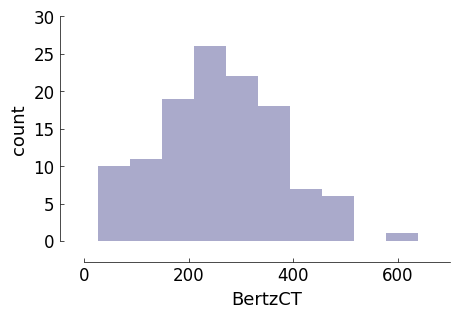

In [66]:
plt.figure(figsize=(5, 5 / 1.618), dpi=100)
plt.style.use("lamalab.mpl")  # Use the custom style for plotting
FONT_FILE = "CMU Sans Serif.ttf"
font_path = Path(FONT_FILE)
fm.fontManager.addfont(font_path)

plt.hist(
    data["bertz_complexity"],
    bins=10,
    alpha=0.5,
    color="#565698b3",
)


range_frame(x=np.array([0, 700]), y=np.array([0, 30]), ax=plt.gca(), pad=0.03)
plt.xlabel("BertzCT")
plt.ylabel("count")